# АБ-тесты проект. Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

**ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи  
**ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ  
**ab_products** – подробная информация о продуктах, их название и стоимость

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import stats as stst


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
users_data = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

# <a id="title1"> EDA </a>

[К анализу метрик ↓](#title2)  

[К общему выводу ↓↓↓](#Conclusion2)

In [3]:
def df_info(dataframe, df_name = 'df', info_params = ['total']):
    """
    Функция выводит на экран описательную статистику датафрейма
    dataframe - датафрейм
    df_name - имя датафрейма, по умолчанию 'df'
    info_params - какую информацию вывести. Принимает параметры списком по умолчанию 'total' - вся информация
    """
    print(f"\033[1m{df_name}\033[0m")
    for info_param in info_params:
        if info_param == 'shape':
            print(f"Размер:\n{dataframe.shape}", sep = '')
        if info_param == 'dtypes':
            print(f"\nТипы переменных:\n{dataframe.dtypes}", sep = '')
        if info_param == 'isna':
            print(f"\nНаличие NaN:\n{dataframe.isna().sum()}", sep = '')
        if info_param == 'describe':
            print(f"\nОписательная статистика:\n{dataframe.describe().round(2)}", sep = '')

    if info_params[0] == 'total':
        print(f"Размер:\n{dataframe.shape}", sep = '')
        print(f"\nТипы переменных:\n{dataframe.dtypes}", sep = '')
        print(f"\nНаличие NaN:\n{dataframe.isna().sum()}", sep = '')
        print(f"\nОписательная статистика:\n{dataframe.describe().round(2)}\n", sep = '')
        


def duplicates_order_id_df():
    """
    Функция, возвращающая датафрейм только с дубликатами в order_id, то есть 
    строки с созданными заказами и строки с соответствующим отмененными заказами 
    """
    return users_data.loc[users_data \
                          .order_id \
                          .isin(users_data \
                                .loc[users_data.action == 'cancel_order'] \
                                .order_id)]

def ttest_conditions(df, sample_1, sample_2, x_dist, hue_dist):
    '''
    Проверка на нормальность распределния экспериментальных выборок перед 
    применением статистического параметрического теста
    '''
    sns.displot(df, x = x_dist, hue = hue_dist, kde = True, bins = 50)
    plt.show()

    print('Ср. отклонение контрольной группы: ', np.std(sample_1))
    print('Ср. отклонение тестовой группы: ', np.std(sample_2))

    print('p-value гомогенности дисперсий: ', stats.levene(sample_1, sample_2)[1])

    print('\np-value нормальности для контрольной группы: ', stats.shapiro(sample_1)[1])
    print('p-value нормальности для тестовой группы: ', stats.shapiro(sample_2)[1])

In [4]:
users_data[:3]

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0


In [5]:
orders[:3]

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"


In [6]:
products[:3]

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4


In [7]:
df_info(users_data, 'users_data')
df_info(orders, 'orders')
df_info(products, 'products')

users_data
Размер:
(4337, 6)

Типы переменных:
user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

Наличие NaN:
user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

Описательная статистика:
       user_id  order_id    group
count  4337.00   4337.00  4337.00
mean   1466.77  16362.86     0.61
std     290.45  16609.67     0.49
min     964.00   1255.00     0.00
25%    1220.00   2444.00     0.00
50%    1463.00   9615.00     1.00
75%    1710.00  26920.00     1.00
max    1980.00  59533.00     1.00

orders
Размер:
(4123, 3)

Типы переменных:
order_id          int64
creation_time    object
product_ids      object
dtype: object

Наличие NaN:
order_id         0
creation_time    0
product_ids      0
dtype: int64

Описательная статистика:
       order_id
count   4123.00
mean   16387.90
std    16644.52
min     1255.00
25%     2444.50
50%     9614.00
75%    27000.00
max    59533.0

In [8]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


Проверю, статусы в action для каждого заказа только по одному, или в датасете для каждого заказа будет и create_order, и cancel_order в случае отмены

In [9]:
users_data.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [10]:
users_data.order_id.nunique()

4123

In [11]:
users_data.query("action == 'cancel_order'")[:1]

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0


In [12]:
users_data.query("order_id == '1258'")

,user_id,order_id,action,time,date,group
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0


Заказ дублируется новой строчкой с новой датой в датафрейме в случае отмены, но на всякий случай проверю, что это касается всех заказов

In [13]:
duplicates_order_id_df().action.value_counts()

create_order    214
cancel_order    214
Name: action, dtype: int64

Проверю, совпадают ли даты в двух колонках, затем переведу в формат datetime

In [14]:
(pd.to_datetime(users_data.time).dt.date == pd.to_datetime(users_data.date)) \
    .value_counts()

True    4337
dtype: int64

In [15]:
users_data.time = pd.to_datetime(users_data.time)
users_data.date = pd.to_datetime(users_data.date)

Проверю уникальное количество значений во всех колонках

In [16]:
users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

Любопытно, что общее кол-во строк во фрейме не совпадает с кол-вом уникальных значений в time. Думаю, это связано совпадениями по секундам. Также обращу внимание, что в среднем пользователи совершили около 4 заказов

In [17]:
print('Начало эксперимента: ', users_data.date.min(), 
      '\nКонец эксперимента: ', users_data.date.max(),
      '\nЧисло дней экспериента: ', users_data.date.max() - users_data.date.min() + timedelta(days = 1))

Начало эксперимента:  2022-08-26 00:00:00 
Конец эксперимента:  2022-09-08 00:00:00 
Число дней экспериента:  14 days 00:00:00


Проверим следующие распределения:

In [18]:
# Всех заказов (включая дубликаты от отмен)
users_data.group.value_counts()

1    2646
0    1691
Name: group, dtype: int64

In [19]:
# Всех заказов (не включая дубликаты)
users_data.loc[users_data.action == 'create_order'].group.value_counts()

1    2514
0    1609
Name: group, dtype: int64

In [20]:
# Не отмененных заказов
users_data.loc[users_data.order_id.isin(users_data
                                        .loc[users_data.action == 'cancel_order']
                                        .order_id) == False] \
    .query("action == 'create_order'").group.value_counts()

1    2382
0    1527
Name: group, dtype: int64

In [21]:
# Отмененных заказов (не учитывая дубликаты)
duplicates_order_id_df().query("action == 'create_order'").group.value_counts()

1    132
0     82
Name: group, dtype: int64

In [22]:
# Пользователей по экспериментальным группам
users_data.groupby('group', as_index = False).agg({'user_id' : 'nunique'}).user_id

0    515
1    502
Name: user_id, dtype: int64

В целом, экспериментальные группы почти равны по пользователям.  
Также для вычисления некоторых метрик удобнее работать с недублирующимеся айдишниками товаров, поэтому введу дополнительную колонку, где будет информация об отмене товара, и занесу в новый датафрейм без дубликатов id заказов

In [23]:
users_data['is_canceled'] = users_data \
    .order_id \
    .isin(duplicates_order_id_df().order_id)

users_clean = users_data.drop_duplicates(subset = ['order_id'])

In [24]:
users_clean[:3]

,user_id,order_id,action,time,date,group,is_canceled
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,False
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,False


## Мердж датафреймов

1. Развернем список продуктов в датафрейме **order_id**, переведя значения из строки в список значений int, и сольем его с датафреймом **products**  
2. Сольем получившийся датафрейм с **users_clean**

In [25]:
orders['product_ids'] = orders.product_ids.apply(lambda x: [int(i) for i in x.strip('{}').split(', ')])
orders = orders.explode('product_ids')
orders.rename(columns = {'product_ids' : 'product_id'}, inplace = True)

In [26]:
orders[:3]

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53


In [27]:
orders_n_products = orders.merge(products, on = 'product_id')
orders_n_products.creation_time = pd.to_datetime(orders_n_products.creation_time)

general_clean = users_clean.merge(orders_n_products, on = 'order_id')

In [28]:
# orders_n_products

In [29]:
general_clean.head()

,user_id,order_id,action,time,date,group,is_canceled,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,False,2022-08-26 00:02:21,56,сосиски,150.0


**general_clean** - наш итоговый датафрейм, содержащий информацию по продуктом в каждом заказе и информацию о заказах для каждого пользователя

[К началу ↑↑↑](#title1)

# <a id="title2"> Анализ данных </a>

[К метрике ARPPU](#ARPPU2)

[К метрике АOV](#AOV2)

[К метрике OCR](#OCR2)

[К общему выводу ↓↓↓](#Conclusion2)

# Выбор метрик
### <a id="mark2"> Подходящие метрики </a>
I. **Метрики прибыли**
1. **Revenue**. Общая выручка.
2. **ARPPU**. Общий доход от платящих пользователей / Количество платящих пользователей.
3. **AOV**. Сумма от всех покупок / Количество покупок.

II. **Метрики активности пользователей**
1. **DAU**. Количество активных пользователей в день.
2. **Sickness**. (Средний DAU) / WAU

III. **Метрики оттока**
1. **Product Return Rate**. Количество возвращенных товаров / Общее количество проданных товаров * 100%.
2. **Churn rate**. Количество потерянных покупателей в конце периода, деленное на общее количество в начале периода

Выше перечислены возможные метрики, которыми мы могли бы оценить качество нашего сервиса. Не секрет, что некоторые из них будут менее подходящими для этой оценки. Например, считаю, что такая метрика, как Churn rate, лучше применима для более продолжительного периода, чем 14 дней. Даже не смотря на то, что среднее число покупок ~4, такой временной промежуток не достаточен для какого-либо вывода по коэффициенту оттоку юзера. 
  
 
- В качестве метрик, которые оценят прибыль с двух смежных сторон, я возьму метрики **ARPPU** и **AOV**.   
    - Метрика ARPPU отражает среднюю выручку от каждого платящего пользователя и может дать более целостное представление об этой группе. Таким образом, изменения этой метрики в лучшую сторону может дать сигнал об увеличении размера базы платежеспособных покупателей. То есть значение ARPPU подскажет нам, что пользователи сталли больше тратить, вследствие внедрения новой рекомендательной системы.
    - Метрика AOV отражает средний чек по заказам. В целом она схожа с ARPPU за исключением того, что мы будем искать различия в размере заказов, а не в размере трат пользователей. Результаты изменений отразят информацию о том, как много пользователь стал покупать за раз. Отмечу, что эта метрика меньше коррелирует с метрикой Revenue, т.к. на выручку еще влияет частота покупок. 
- В качестве метрики, которая оценит частоту отмен, я модифицирую метрику **Product Return Rate**, подставив вместо количества возвратов количество отмен. Такая уже есть и называется она **Order Cancellation Rate**. Отмены позволят взглянуть на изменения в экспериментальных группах с другой стороны - стороны отмен покупок, то издержек нашей рекомендательной из-за которых пользователи передумали.

### Итак, выбранные метрики:
1. **ARPPU** - целевая
2. **AOV** - прокси
3. **Order Cancellation Rate** - прокси

# Метрика Revenue

Нельзя не упомянуть основную метрику для большинста бизнесов - общую выручку. В качестве датафрейма для работы с данными и исследования метрик я возьму general_clean и буду исключать отмененные заказы для исследований. Исключением будет являться метрика OCR, в которой я изучу ситуацию с отменами.

In [30]:
products_not_canceled = general_clean.query("is_canceled == False")

In [31]:
products_not_canceled[:3]

,user_id,order_id,action,time,date,group,is_canceled,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,53,мука,78.3


In [32]:
revenue_df_preview = products_not_canceled.groupby('group', as_index = False) \
    .agg({'price' : 'sum', 'user_id' : 'nunique'}) \
    .rename(columns = {'price' : 'revenue', 'user_id' : 'user_count'})
revenue_df_preview

,group,revenue,user_count
0,0,583455.9,512
1,1,878628.4,501


In [33]:
print('Разница между общей выручкой от тестовой группы =', revenue_df_preview['revenue'][1].round(1), 
      'и контрольной группы =', revenue_df_preview['revenue'][0].round(1), 'равняется', 
      revenue_df_preview['revenue'][1].round(1) - revenue_df_preview['revenue'][0].round(1))

Разница между общей выручкой от тестовой группы = 878628.4 и контрольной группы = 583455.9 равняется 295172.5


[К списку метрик↑↑↑](#mark2)

# Метрика ARPPU

<a id="ARPPU2"> ARPPU </a>

[К метрике АOV↓](#AOV2)

In [34]:
# Посмотрим на наши средние выручки с пользователей в двух группах
ARPPU_preview_df = products_not_canceled.groupby('group', as_index = False) \
    .agg({'price' : 'sum', 'user_id' : 'nunique'}) \
    .rename(columns = {'price' : 'revenue', 'user_id' : 'user_count'})
ARPPU_preview_df['ARPPU'] = ARPPU_preview_df.revenue / ARPPU_preview_df.user_count
ARPPU_preview_df

,group,revenue,user_count,ARPPU
0,0,583455.9,512,1139.562305
1,1,878628.4,501,1753.749301


Средняя потраченная сумма пользователя в тестовой группе больше, чем в контрольной. Проведем тесты, чтобы проверить статистическую значимость разницы средних

### Формулировка гипотез
**H<sub>0</sub>** - средние в контрольной и экспериментальной группе статистически значимо **не различаются**. То есть различия ARPPU случайны   
**H<sub>1</sub>** - средние в контрольной и экспериментальной группе статистически значимо **различаются**. То есть в различиях ARPPU есть закономерность 

In [35]:
# Возьмем только нужные нам переменные
ARPPU_df = products_not_canceled[['group', 'user_id', 'price']]

In [36]:
ARPPU_df = ARPPU_df.groupby(['group', 'user_id'], as_index = False).agg({'price' : 'sum'})

In [37]:
ARPPU_df.head()

,group,user_id,price
0,0,964,718.9
1,0,968,1590.7
2,0,969,681.9
3,0,972,546.4
4,0,975,1432.9


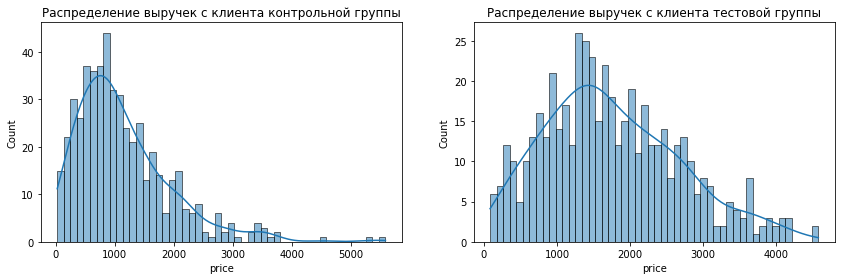

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(ARPPU_df.query("group == 0").price, ax=axes[0], bins = 50, kde = True)
axes[0].set_title('Распределение выручек с клиента контрольной группы')

sns.histplot(ARPPU_df.query("group == 1").price, ax=axes[1], bins = 50, kde = True)
axes[1].set_title('Распределение выручек с клиента тестовой группы')

plt.tight_layout() 
plt.show()


### Проверка на параметрические условия

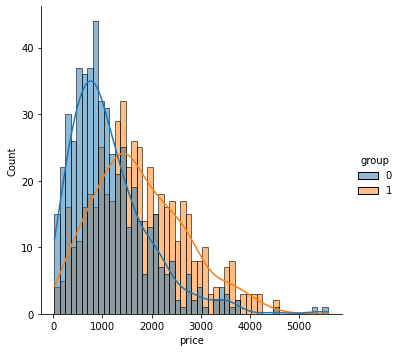

Ср. отклонение контрольной группы:  809.017708520745
Ср. отклонение тестовой группы:  927.8335669335605
p-value гомогенности дисперсий:  1.896012459520485e-05

p-value нормальности для контрольной группы:  8.713836969217895e-19
p-value нормальности для тестовой группы:  1.408598961916141e-07


In [39]:
ttest_conditions(ARPPU_df, 
                 ARPPU_df.loc[ARPPU_df.group == 0].price, 
                 ARPPU_df.loc[ARPPU_df.group == 1].price, 
                 ARPPU_df.price, 
                 ARPPU_df.group)

Видно, что распределения визуально близки к нормальным, однако тест Шапиро-Уилка нам это не показал (вероятно из-за сильной чувствительности к выбросам) - p-value < &alpha; (&alpha; = 0.05 далее). Помимо этого, не соблюдены требования гомогенности дисперсий. **Параметрические условия не соблюдены**. Пробую пролагорифимровать:

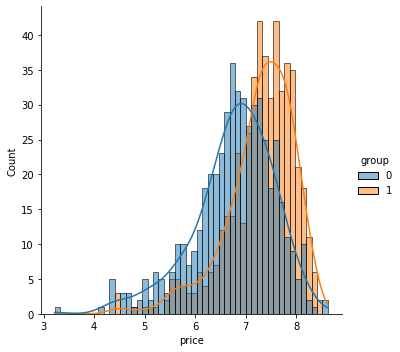

Ср. отклонение контрольной группы:  0.8059337981940001
Ср. отклонение тестовой группы:  0.6778247104093954
p-value гомогенности дисперсий:  0.0005415443168401095

p-value нормальности для контрольной группы:  7.013428171553926e-10
p-value нормальности для тестовой группы:  2.724891650548165e-15


In [40]:
ttest_conditions(ARPPU_df, 
                 np.log(ARPPU_df.loc[ARPPU_df.group == 0].price), 
                 np.log(ARPPU_df.loc[ARPPU_df.group == 1].price), 
                 np.log(ARPPU_df.price), 
                 ARPPU_df.group)

p-value снова < α и в проверке на нормальность, и в проверке на гомогенность дисперсий.  
  
  Итак, **выбираю непараметрический стат тест Манна-Уитни**, как основной. Я также проверю стат значимость Т-тестом Стьюдента, т.к. визуально распределения близки к нормальным

### Стат тесты

#### Тест Манна-Уитни

In [41]:
stats.mannwhitneyu(ARPPU_df.loc[ARPPU_df.group == 0].price,
                   ARPPU_df.loc[ARPPU_df.group == 1].price)

MannwhitneyuResult(statistic=75130.0, pvalue=3.687870151753067e-30)

p-value < &alpha; -> изменения статсзначимы

#### Т-тест 

In [42]:
stats.ttest_ind(ARPPU_df.loc[ARPPU_df.group == 0].price,
                ARPPU_df.loc[ARPPU_df.group == 1].price)

Ttest_indResult(statistic=-11.225235903309475, pvalue=1.2229806926590051e-27)

p-value < &alpha; -> изменения статсзначимы

#### Bootstrap

Применю методику bootstrap, просимулировав эксперимент для каждой экспериментальной группы 9999 раз, и посчитаем 95% доверительные интервалы для средних:

In [43]:
stats.bootstrap((ARPPU_df.loc[ARPPU_df.group == 0].price, ), statistic = np.mean) \
    .confidence_interval

ConfidenceInterval(low=1073.771725502968, high=1215.8890617596608)

In [44]:
stats.bootstrap((ARPPU_df.loc[ARPPU_df.group == 1].price, ), statistic = np.mean) \
    .confidence_interval

ConfidenceInterval(low=1673.1633101501147, high=1833.7100985970305)

In [45]:
ARPPU_preview_df

,group,revenue,user_count,ARPPU
0,0,583455.9,512,1139.562305
1,1,878628.4,501,1753.749301


In [46]:
ARPPU_diff = ARPPU_preview_df['ARPPU'][1] - ARPPU_preview_df['ARPPU'][0]
ARPPU_diff

614.1869967097639

### Вывод по метрике ARPPU

Проведенный тест **Манна-Уитни** и в том числе **Т-тест** дают нам повод опровергнуть **H<sub>0</sub>** в пользу **H<sub>1</sub>**. Таким образом, мы можем быть на более чем 95%-в уверены, что среднее значение ARPPU в экспериментальной группе будет стат значимо различаться со средним ARPPU в контрольной группе.  
Подтверждением вышесказанного также является вычисление 95%-х доверительных интервалов средних методикой **Bootstrap**. Как мы видим, интервалы не имеют пересечений среди своих 2.5%-х и 97.5%-х квантилей.  
  
  **В итоге мы имеем статзначимые изменения ARPPU в экспериментальной группе по сравнинию с контрольной, причем эти изменения положительны и равняются примерно `ARPPU_diff = 614`**

[К метрике ARPPU↑](#ARPPU2)

[К списку метрик↑↑↑](#mark2)

# Метрика AOV

<a id="AOV2">AOV</a>

[К метрике OCR↓](#OCR2)

In [47]:
products_not_canceled[:3]

,user_id,order_id,action,time,date,group,is_canceled,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,False,2022-08-26 00:00:19,53,мука,78.3


Посмотрим на различия между средними выручками с пользователей в двух группах, а также различия в метриках AOV

In [48]:
AOV_preview_df = products_not_canceled.groupby('group', as_index = False) \
    .agg({'price' : 'sum', 'order_id' : 'nunique'}) \
    .rename(columns = {'price' : 'revenue', 'order_id' : 'order_count'})
AOV_preview_df['AOV'] = AOV_preview_df.revenue / AOV_preview_df.order_count

In [49]:
AOV_preview_df

,group,revenue,order_count,AOV
0,0,583455.9,1527,382.092927
1,1,878628.4,2382,368.861629


Различия между выручками положительное, как и в количествах заказов, но средний чек в тестово группе меньше, чем в контрольной. Проверим, насколько эти различия стат значимы.

### Формулировка гипотез
**H<sub>0</sub>** - средние чеки в контрольной и экспериментальной группе статистически значимо **не различаются**. То есть различия AOV случайны   
**H<sub>1</sub>** - средние чеки в контрольной и экспериментальной группе статистически значимо **различаются**. То есть в различиях AOV есть закономерность 

In [50]:
# Возьмем только нужные нам переменные и посчитаем каждый чек
AOV_df = products_not_canceled[['group', 'order_id', 'price']]
AOV_df = AOV_df.groupby(['group', 'order_id'], as_index = False) \
    .agg({'price' : 'sum'})

In [51]:
AOV_df.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1261,430.7
3,0,1262,358.6
4,0,1265,546.4


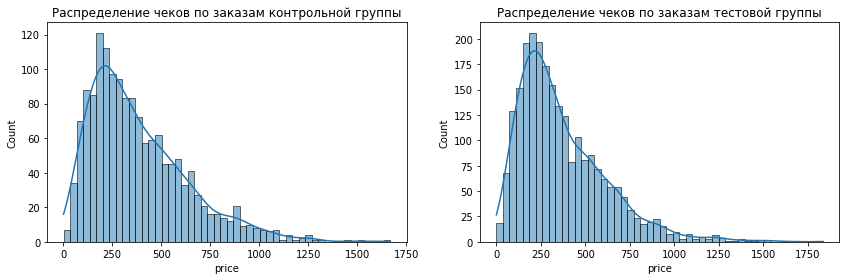

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(AOV_df.query("group == 0").price, ax=axes[0], bins = 50, kde = True)
axes[0].set_title('Распределение чеков по заказам контрольной группы')

sns.histplot(AOV_df.query("group == 1").price, ax=axes[1], bins = 50, kde = True)
axes[1].set_title('Распределение чеков по заказам тестовой группы')

plt.tight_layout() 
plt.show()


### Проверка на параметрические условия

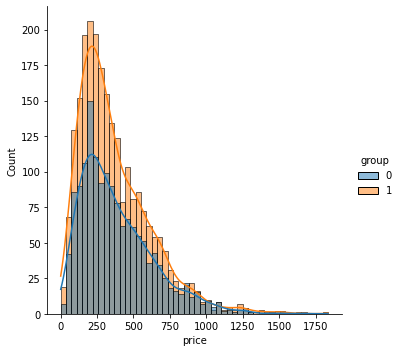

Ср. отклонение контрольной группы:  247.91207163235208
Ср. отклонение тестовой группы:  246.44732928056123
p-value гомогенности дисперсий:  0.31453758452176295

p-value нормальности для контрольной группы:  3.811183766866527e-28
p-value нормальности для тестовой группы:  8.388620126125922e-37


In [53]:
ttest_conditions(AOV_df, 
                 AOV_df.loc[AOV_df.group == 0].price, 
                 AOV_df.loc[AOV_df.group == 1].price, 
                 AOV_df.price, 
                 AOV_df.group)

Видно, что распределения визуально близки к нормальным, однако тест Шапиро-Уилка нам это не показал (вероятно из-за сильной чувствительности к выбросам) - p-value < α .  
Применив тест Левена, по результатам гомогенности дисперсий мы не можем говорить о стат значимости различий дисперсий, т.к. p-value > α.  
Параметрические условия соблюдены частично. Пробую пролагорифимровать:

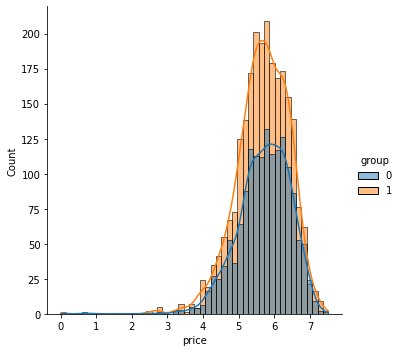

Ср. отклонение контрольной группы:  0.7166016362972587
Ср. отклонение тестовой группы:  0.7279365460672499
p-value гомогенности дисперсий:  0.9308393903398693

p-value нормальности для контрольной группы:  2.2001176820326835e-15
p-value нормальности для тестовой группы:  1.7065833020632874e-20


In [54]:
ttest_conditions(AOV_df, 
                 np.log(AOV_df.loc[AOV_df.group == 0].price), 
                 np.log(AOV_df.loc[AOV_df.group == 1].price), 
                 np.log(AOV_df.price), 
                 AOV_df.group)

p-value снова < α и в проверке на нормальность, но > α в проверке на гомогенность дисперсий.

Итак, выбираю непараметрический стат тест Манна-Уитни, как основной. Я также проверю стат значимость Т-тестом Стьюдента, т.к. визуально распределения близки к нормальным

### Стат тесты

#### Тест Манна-Уитни

In [55]:
stats.mannwhitneyu(AOV_df.loc[AOV_df.group == 0].price,
                   AOV_df.loc[AOV_df.group == 1].price)

MannwhitneyuResult(statistic=1879866.0, pvalue=0.07540906614048998)

#### Т-тест 

In [56]:
stats.ttest_ind(AOV_df.loc[AOV_df.group == 0].price,
                AOV_df.loc[AOV_df.group == 1].price)

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234669)

В обоих случаях p-value > &alpha;, но незначительно. Это значение не позволяет опровергнуть H<sub>0</sub> и сказать, что уменьшение среднего чека в тестовой выборке статистически значимо.  
  
  
Однако стоит отметить, что обе выборки несколько смещены влево, а также имеют заметные хвосты справа. Несомненно экстремальные значения и выбросы оказывают влияние на среднее значение, в связи с этим, полагаться только на результат тестов оценки средних значений может быть опрометчиво.  

Методика Bootstrap, возможно, позволит нам дать более точную статистическую оценку различий средних и медиан, в частности.

#### Bootstrap 

**H<sub>0</sub>** в этом случае - медианные чеки в контрольной и экспериментальной группе статистически значимо не различаются. То есть различия медианных чеков случайны

In [57]:
print('Медианы в группах равны: ', 
      AOV_df.loc[AOV_df.group == 0].price.median(), 
      'и', 
      AOV_df.loc[AOV_df.group == 1].price.median())

Медианы в группах равны:  325.9 и 307.35


In [58]:
print('95% доверительные интервалы в группах равны: ', 
      stats.bootstrap((AOV_df.loc[AOV_df.group == 0].price, ), statistic = np.median) \
     .confidence_interval,
     'и',
     stats.bootstrap((AOV_df.loc[AOV_df.group == 1].price, ), statistic = np.median) \
     .confidence_interval)

95% доверительные интервалы в группах равны:  ConfidenceInterval(low=310.2, high=338.3) и ConfidenceInterval(low=295.0, high=318.3)


Посмотрю на разницу медиан:

In [59]:
tmp_1 = AOV_df.loc[AOV_df.group == 0].price
tmp_2 = AOV_df.loc[AOV_df.group == 1].price
median_diff = []
median_control_list = []
median_exp_list = []

for i in range(10000):
    sample_data_control = tmp_1.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.median()
    median_control_list.append(sample_median_control)

    sample_data_exp = tmp_2.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.median()
    median_exp_list.append(sample_median_exp)
    
    sample_median_diff = sample_median_control - sample_median_exp
    
    median_diff.append(sample_median_diff)

In [60]:
print('95%-й доверительный интервал для разниц медианных значений,\nполученных методикой Bootstrap: [',
      pd.Series(median_diff).quantile(0.025).round(3), ', ', 
      pd.Series(median_diff).quantile(0.975).round(3), ']')

95%-й доверительный интервал для разниц медианных значений,
полученных методикой Bootstrap: [ 0.4 ,  36.45 ]


Итак, методом Бутстрэпа мы выяснили, что 95%-е доверительные интервалы медиан, взятых по выборкам с повторениями, в двух экспериментальных группах пересекаются друг с другом. Это означает, что различия между медианами `325.9` для контрольной и `307.35` для тестовой группы не являются статистически значимы, то есть у нас недостаточно оснований отклонить **H<sub>0</sub>** для медиан

### Вывод по метрике ARPPU

Проведенные тесты **Манна-Уитни** и **Т-тест** не дают нам повод опровергнуть **H<sub>0</sub>** и считать, что изменение средних чеков в худшую сторону в тестовой группе статистически значимо.  
В качестве проверки мною была проведено исследование стат значимых различий медиан двух групп методикой **Bootstrap**. Данный метод показал, что стат значимых изменений в медианах чеков также нет.  
**В итоге у меня не получилось обнаружить стат значимых различий, т.е. закономерность в изменениях в худшую сторону в средних `AOV` в размере `13.13` и в медианах в размере `18.56`**

[К метрике АOV↑](#AOV2)

[К списку метрик↑↑↑](#mark2)

# Order Cancellation Rate

<a id="OCR2"> OCR </a>

[К метрике общему выводу↓](#Conclusion2)

`OCR = Количество отмененных товаров / Общее количество всех изначально проданных товаров  * 100%`

Можно сказать, мы считаем конверсию в отмену товара среди всех покупок товаров

### Формулировка гипотез

**H<sub>0</sub>** - Отношение количества отмен к общему количеству покупок не зависит от экспериментальной группы, то есть примерно одинаково  
**H<sub>1</sub>** - Отношение количества отмен к общему количеству покупок  зависит от экспериментальной группы, то есть стат значимо различается

Посмотрим на различия между отменами и метриками OCR в двух экспериментальных группах

In [61]:
OCR_df_preview = general_clean[['user_id', 'group', 'is_canceled']]
OCR_df_preview = OCR_df_preview.groupby('group', as_index = False) \
    .agg({'is_canceled' : 'sum', 'user_id' : 'count'}) \
    .rename(columns = {'is_canceled' : 'canceled_products', 'user_id' : 'total_products'})
OCR_df_preview['OCR'] = OCR_df_preview.canceled_products / OCR_df_preview.total_products * 100 

In [62]:
OCR_df_preview

,group,canceled_products,total_products,OCR
0,0,287,5390,5.324675
1,1,456,8436,5.405405


Различия между отменами присутствуют, однако это не дает нам оснований утверждать, что они выросли в результате падения качества товара - возможно, рост отмен связан с общим увеличением спроса на товары. Это мы и проверяем метрикой OCR.

Различия метрик присутствуют, хоть и незначительные, проверим их на стат значимость. Метод **Хи-квадрат** будет подходящим, т.к. мы имеем дело с двумя номинативными переменными: статус отмены и тип экспериментальной группы.

#### Таблица сопряженности

In [63]:
products_crosstab = OCR_df_preview
products_crosstab['non_canceled_products'] = (products_crosstab['total_products'] - 
                                     products_crosstab['canceled_products'])

In [64]:
products_crosstab.set_index('group', inplace = True)
products_crosstab = products_crosstab.append(products_crosstab.sum(), ignore_index=True) \
    .rename(index = {0 : 'control', 1 : 'test', 2 : 'total'})
products_crosstab = products_crosstab[['canceled_products', 'non_canceled_products', 'total_products']]

In [65]:
products_crosstab

,canceled_products,non_canceled_products,total_products
control,287.0,5103.0,5390.0
test,456.0,7980.0,8436.0
total,743.0,13083.0,13826.0


#### Тест Хи-квадрат

In [66]:
stats.chi2_contingency(products_crosstab.drop(index = 'total', columns = 'total_products'))

(0.027769102315947473,
 0.8676528160493342,
 1,
 array([[ 289.65499783, 5100.34500217],
        [ 453.34500217, 7982.65499783]]))

### Вывод по метрике OCR

Проведенный тест **Хи-квадрат** не дает нам оснований опровергнуть **H<sub>0</sub>** в пользу **H<sub>1</sub>**, т.к. p-value ~0.86 > &alpha;.  
**Таким образом, мы ничего не можем сказать о статистически значимом распределении отмен по экспериментальным группам, а следовательно различии метрик `OCR` между контрольной и тестовой группой.**

[К метрике OCR↑](#OCR2)

[К списку метрик↑↑↑](#mark2)

# <a id="Conclusion2"> Общий вывод </a>

Во-первых, наша рекомендательная система положительно повлияла на изменение `общей выручки` (отмененные заказы не учитываются). В старой версии - `583455`, в новой - `878628`.  
Во-вторых, рекомендательная система положительно повлияла на на общее `число заказов` (отмененные заказы не учитываются). В старой версии - `1527`, в новой - `2382`.

Статистический анализ целевой метрики `ARPPU` показал, что мы имеем закономерность в увеличении средней выручки на платящего пользователя на `614` (отмененные заказы не учитываются). В старой версии - `1140`, в новой - `1754`. Считаю, что этот показатель хорошо отражает результат прибыли от рекомендательной системы.

Статистический анализ прокси-метрики `AOV` не показал, что мы имеем закономерность в уменьшении среднего чека на `13.13`(отмененные заказы не учитываются). В старой версии - `382.1`, новой - `368.8`. Таким образом, мы не можем однозначно сделать заключение. 

Статистический анализ прокси-метрики `OCR` не показал, что мы имеем закономерности в увеличении количества отмен товаров на общее количество всех проданных товаров. Так или иначе, разница этой метрики была очень мала - `<0.08%` (в старой - `5.32%`, в новой - `5.40%`), и вряд ли окажет какое-либо влияние на наш бизнес. 

Обобщая вышесказанное, считаю, что, к сожалению, выбранные мной метрики недостаточны для максимально точного многогранного оценивания профита от рекомендательной системы. Возможно, хорошей практикой было бы исследовать метрику `AOV` в связке с метрикой среднего количества покупок на пользователя. Также можно было бы статистически оценить пару из метрик среднего прайса на товары и среднего числа покупок товаров. Также можно было бы расчитать такую метрику, как Stickness, оценив частоту покупок пользователей.  
  
  
**Тем не менее анализ ключевой метрики `ARPPU` показал заметное стат значимое увеличение метрики. Поэтому считаю, что рекомендательная система положительно повлияла на бизнес и скорее принесет ему пользу в будущем, поэтому, думаю, ее стоит включить на всех пользователей.**

[К началу ↑↑↑](#title1)